In [1]:
import os
import sys

# Set the parent folder (of operator_learning) as the working directory and home for imports
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(parent_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


In [2]:
from godunov_solver.solve_class import *

nx = 50
nt = 100
dx = 0.25
dt = 0.05
bc = "GhostCell"
ic = "RiemannProblem"


In [10]:
#import torch Dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

# def gen_grid(solver, nx, nt, dx, dt, bc):
#     ic = "PiecewiseConstant"
#     # Random number of steps
#     n_steps = np.random.randint(1, 10)

#     # Random values of steps
#     steps = sorted(np.random.randint(0, nx, size=n_steps))

#     # Random v for each step, between 0 and 1
#     values = np.random.rand(n_steps)

#     grid = Grid(nx, nt, dx, dt, ic, bc, values=values, steps=steps)
#     solver.solve(grid)
#     return grid.grid['h']
    
def gen_grid(solver, nx, nt, dx, dt, bc):
    ic = "RiemannProblem"
    # Random number of steps
    step = np.random.randint(0, nx)    

    # Random v for each step, between 0 and 1
    uL = np.random.rand()
    uR = np.random.rand()

    grid = Grid(nx, nt, dx, dt, ic, bc, step=step, uL=uL, uR=uR)
    solver.solve(grid)
    return grid.grid['h']
    

class GridDataset(Dataset):
    def __init__(self, n_samples, nx, nt, dx, dt, bc, **kwargs):
        self.n_samples = n_samples
        self.bc = bc
        solver = GodunovLWR(flux=GreenshieldsFlux(vmax=1.0, rho_max=1.0))
        self.grids = []
        for _ in tqdm(range(n_samples), desc="Generating grids"):
            self.grids.append(gen_grid(solver, nx, nt, dx, dt, bc))

    def __len__(self):
        return len(self.grids)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.grids[idx]).to(torch.float32).unsqueeze(-1)

dataset = GridDataset(n_samples=5000, nx=nx, nt=nt, dx=dx, dt=dt, bc="GhostCell")


Generating grids:   3%|▎         | 169/5000 [00:07<03:26, 23.41it/s]


KeyboardInterrupt: 

In [4]:
from torch.utils.data import DataLoader
from neuralop.models import FNO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import math
import random

def _stack_time_window(win):  # win: (B, T, nx, C) -> (B, nx, T*C)
    B, T, nx, C = win.shape
    return win.permute(0, 2, 1, 3).reshape(B, nx, T * C)

def train_autoreg_epoch(
    model,
    loader: DataLoader,     # yields batches u: (B, nt, nx, C)
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    T: int,                 # history length
    teach_prob: float = 0.7,# scheduled sampling prob of using ground truth
    add_coord: bool = False, # append x \in [0,1] as a channel
    clip_grad: float | None = None,
    loss_fn = nn.MSELoss(reduction="mean"),
):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for u in loader:
        # u: (B, nt, nx, C)
        u = u.to(device)
        B, nt, nx, C = u.shape
        assert nt > T, "nt must be greater than the history length T."

        # Precompute coordinate channel if desired: (B, nx, 1)
        if add_coord:
            xcoord = torch.linspace(0.0, 1.0, nx, device=device)[:, None]  # (nx,1)
            xcoord = xcoord.expand(nx, 1).unsqueeze(0).expand(B, nx, 1)    # (B,nx,1)

        # Rolling window initialized with first T frames
        # win: (B, T, nx, C)
        win = u[:, :T, :, :].clone()

        total_loss = 0.0
        n_steps = 0

        optimizer.zero_grad(set_to_none=True)

        # Autoregressive rollout across time: predict u_{t} from last T frames
        for t in range(T, nt):
            # Build model input: stack window along channels -> (B, nx, T*C)
            x_in = _stack_time_window(win)  # (B, nx, T*C)

            # Optionally append coordinates: (B, nx, T*C+1)
            if add_coord:
                x_in = torch.cat([x_in, xcoord], dim=-1)

            # Predict next frame
            # Expect model: (B, nx, Cin) -> (B, nx, C)
            # x_in is (B, nx, C_in) at this point
            x_in_cf = x_in.permute(0, 2, 1)     # -> (B, C_in, nx)
            pred_cf = model(x_in_cf)            # model expects (B, C_in, nx), returns (B, C, nx)
            pred = pred_cf.permute(0, 2, 1)     # -> (B, nx, C) to match your target
            # Ground truth for this step
            target = u[:, t, :, :]  # (B, nx, C)

            # Loss for this step
            loss_t = loss_fn(pred, target)
            total_loss = total_loss + loss_t
            n_steps += 1

            # Scheduled sampling: decide what to feed back
            use_teacher = (random.random() < teach_prob)
            next_in = target if use_teacher else pred.detach()  # detach keeps memory in check

            # Update rolling window: drop oldest, append next_in
            # win: (B, T, nx, C)
            if T > 1:
                win = torch.cat([win[:, 1:], next_in.unsqueeze(1)], dim=1)  # shift + append
            else:
                win = next_in.unsqueeze(1)

        # Backprop across the accumulated per-step loss (averaged)
        loss = total_loss / max(1, n_steps)
        loss.backward()

        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(1, n_batches)


In [5]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

history_len = 4
device = torch.device('mps')

model = FNO(
    n_modes=(64,),      # modes kept in each spatial dim
    hidden_channels=128,    # width
    n_layers=6,
    in_channels=1 * history_len,         # your per-point features (e.g., forcing + boundary flag)
    out_channels=1         # predicted field (e.g., solution)
).to(device)
# number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# train_autoreg_epoch(model, dataloader, optimizer, device, history_len)

Number of parameters: 3511041


In [6]:
from tqdm import tqdm

def train_model(model, dataloader, epochs, optimizer, device, history_len):
    teach_probs = 1/np.linspace(1.0, 20.0, epochs)
    # Learning rate scheduler: reduce lr every N epochs or exponentially
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # halve every 5 epochs
    for epoch in tqdm(range(epochs)):
        loss = train_autoreg_epoch(model, dataloader, optimizer, device, history_len, teach_prob=teach_probs[epoch])
        scheduler.step()  # update lr
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1} loss: {loss} lr {current_lr:.6f}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloader, 20, optimizer, device, history_len)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# train_model(model, dataloader, 3, optimizer, device, history_len, teach_prob=0.7)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# train_model(model, dataloader, 3, optimizer, device, history_len, teach_prob=0.3)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# train_model(model, dataloader, 3, optimizer, device, history_len, teach_prob=0.0)

  5%|▌         | 1/20 [00:29<09:27, 29.85s/it]

Epoch 1 loss: 0.12307211570441723 lr 0.001000


 10%|█         | 2/20 [00:58<08:41, 28.99s/it]

Epoch 2 loss: 0.04018221714068204 lr 0.001000


 15%|█▌        | 3/20 [01:27<08:13, 29.02s/it]

Epoch 3 loss: 6119206.624748395 lr 0.001000


 20%|██        | 4/20 [01:56<07:46, 29.16s/it]

Epoch 4 loss: 0.16686300886794925 lr 0.001000


 25%|██▌       | 5/20 [02:25<07:17, 29.15s/it]

Epoch 5 loss: 0.11898061283864081 lr 0.000500


 30%|███       | 6/20 [02:54<06:44, 28.91s/it]

Epoch 6 loss: 0.07870398345403373 lr 0.000500


 35%|███▌      | 7/20 [03:23<06:16, 28.94s/it]

Epoch 7 loss: 0.07170717231929302 lr 0.000500


 40%|████      | 8/20 [03:52<05:47, 28.98s/it]

Epoch 8 loss: 0.07213516905903816 lr 0.000500


 45%|████▌     | 9/20 [04:21<05:18, 28.94s/it]

Epoch 9 loss: 0.07205436285585165 lr 0.000500


 50%|█████     | 10/20 [04:50<04:50, 29.09s/it]

Epoch 10 loss: 0.07265005889348686 lr 0.000250


 55%|█████▌    | 11/20 [05:18<04:19, 28.83s/it]

Epoch 11 loss: 0.07283341744914651 lr 0.000250


 60%|██████    | 12/20 [05:47<03:51, 28.89s/it]

Epoch 12 loss: 0.07269689696840942 lr 0.000250


 65%|██████▌   | 13/20 [06:21<03:32, 30.37s/it]

Epoch 13 loss: 0.07349129859358072 lr 0.000250


 70%|███████   | 14/20 [06:56<03:09, 31.62s/it]

Epoch 14 loss: 0.07283594645559788 lr 0.000250


 75%|███████▌  | 15/20 [07:29<02:40, 32.19s/it]

Epoch 15 loss: 0.07322554988786578 lr 0.000125


 80%|████████  | 16/20 [08:02<02:09, 32.40s/it]

Epoch 16 loss: 0.07260999432764947 lr 0.000125


 85%|████████▌ | 17/20 [08:34<01:36, 32.23s/it]

Epoch 17 loss: 0.07389244739897549 lr 0.000125


 90%|█████████ | 18/20 [09:07<01:04, 32.46s/it]

Epoch 18 loss: 0.07374353520572186 lr 0.000125


 95%|█████████▌| 19/20 [09:43<00:33, 33.60s/it]

Epoch 19 loss: 0.07339473813772202 lr 0.000125


100%|██████████| 20/20 [10:20<00:00, 31.02s/it]

Epoch 20 loss: 0.07390372222289443 lr 0.000063


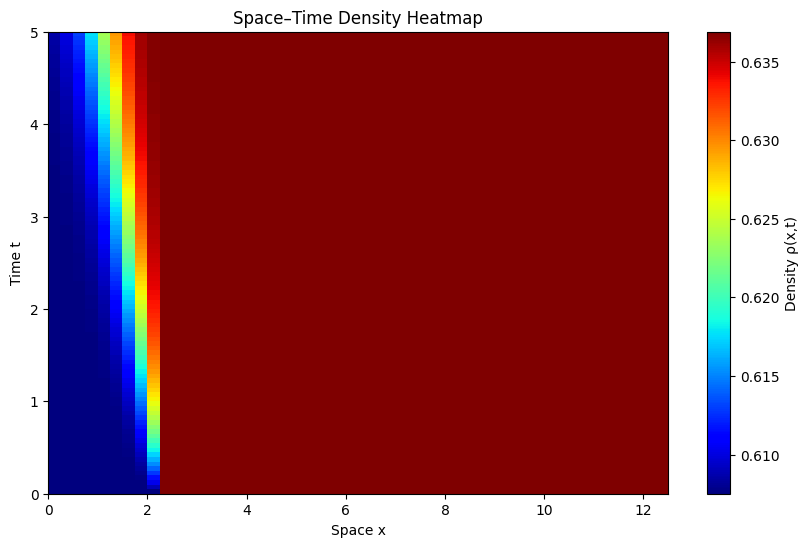

In [7]:
from godunov_solver.plotter import plot_grid_density

plot_grid_density(dataset[1], nx, nt, dx, dt)

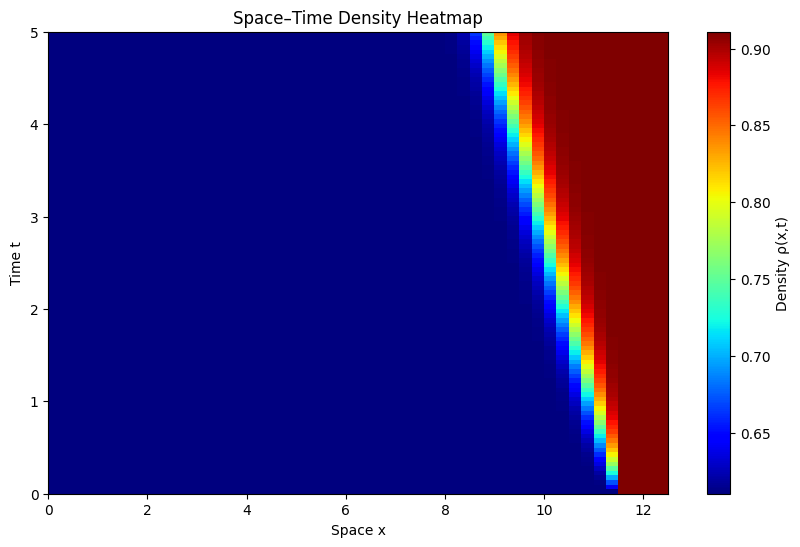

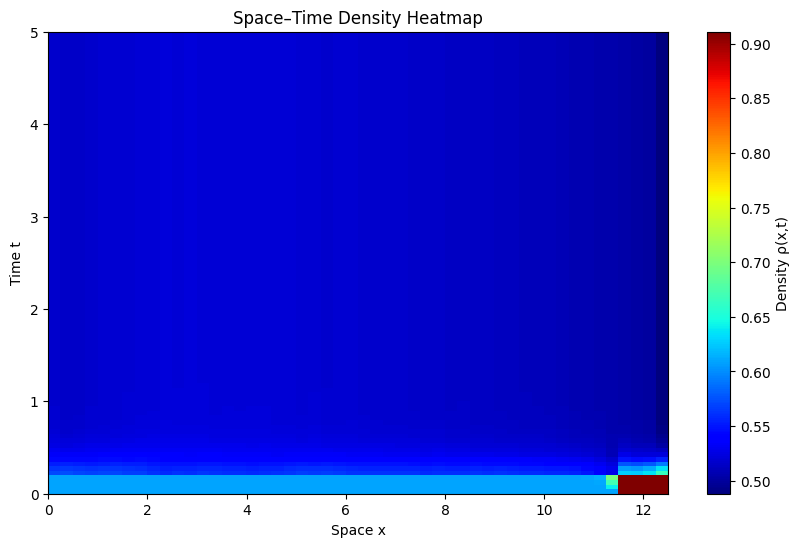

In [8]:
from godunov_solver.plotter import plot_grid_density

def autoreg_rollout(model, u, T, add_coord=False):
    """
    u:   (B, nt, nx, C) full ground truth grid (only first T steps used)
    T:   history length
    out: (B, nt, nx, C) full predicted rollout
    """
    model.eval()
    with torch.no_grad():
        u = u.clone()
        B, nt, nx, C = u.shape
        
        # result buffer filled with zeros, we will fill all timesteps
        out = torch.zeros_like(u)

        # copy the first T truth steps
        out[:, :T] = u[:, :T]

        # build coordinate channel if needed
        if add_coord:
            x = torch.linspace(0, 1, nx, device=u.device)[None, :, None]  # (1, nx, 1)
            x = x.expand(B, nx, 1)  # (B, nx, 1)

        # rolling time window (B, T, nx, C)
        win = out[:, :T].clone()

        for t in range(T, nt):
            # --- build model input ---
            # Stack window: (B, T, nx, C) -> (B, nx, T*C)
            B_, T_, nx_, C_ = win.shape
            x_in = win.permute(0, 2, 1, 3).reshape(B, nx, T * C)

            # append coordinate channel if desired
            if add_coord:
                x_in = torch.cat([x_in, x], dim=-1)     # (B, nx, T*C+1)

            # permute to channels-first for FNO
            x_in_cf = x_in.permute(0, 2, 1)            # (B, C_in, nx)

            # --- predict next frame ---
            pred_cf = model(x_in_cf)                   # (B, C, nx)
            pred = pred_cf.permute(0, 2, 1)            # (B, nx, C)

            # write prediction into output buffer
            out[:, t] = pred

            # update window: drop oldest, append prediction
            if T > 1:
                win = torch.cat([win[:, 1:], pred.unsqueeze(1)], dim=1)
            else:
                win = pred.unsqueeze(1)

        return out

idx = 3
pred = autoreg_rollout(model, dataset[idx].unsqueeze(0).to(device), history_len)
plot_grid_density(dataset[idx], nx, nt, dx, dt)
plot_grid_density(pred[0].cpu().numpy(), nx, nt, dx, dt)